In [1]:
import pathlib
import requests

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model, model_selection, metrics, utils
from sklearn import pipeline, preprocessing

# Working with Real Data

When you are just getting started with machine learning it is best to experiment with real-world data (as opposed to artificial data). The following are some good resources of open-source data that you can use for practice or research.

* [University of California-Irvine Machine Learning Repository](http://archive.ics.uci.edu/ml/)
* [Kaggle](https://www.kaggle.com/datasets),
* [OpenDataMonitor](http://opendatamonitor.eu/),
* [Wikipedia's list of Machine Learning datasets](https://en.wikipedia.org/wiki/List_of_datasets_for_machine-learning_research)
* [Datasets subreddit](https://www.reddit.com/r/datasets/),
* [Quora's list of open datasets](https://www.quora.com/Where-can-I-find-large-datasets-open-to-the-public)

Major cloud providers all have repositories of publically available datasets.,

* [Open Data on AWS](https://registry.opendata.aws/),
* [Open Data on GCP](https://cloud.google.com/public-datasets/),
* [Open Data on Azure](https://azure.microsoft.com/en-us/services/open-datasets/),
    
Finally, [Pandas DataReader](https://pydata.github.io/pandas-datareader/) provides a unified API to a [number of datasets](https://pydata.github.io/pandas-datareader/remote_data.html). Note that many of these data sources require you to create an account and get an API key.

## MNIST Dataset

The original [MNIST](http://yann.lecun.com/exdb/mnist/) dataset consists of 70000 28x28 black and white images in 10 classes. There are 60000 training images and 10000 test images.

In [3]:
# might be different if using Colab or Kaggle
PROJECT_ROOT_DIR = pathlib.Path(".")

DATA_DIR = PROJECT_ROOT_DIR / "data" / "mnist"
DATA_DIR.mkdir(parents=True, exist_ok=True)

RESULTS_DIR = PROJECT_ROOT_DIR / "results" / "mnist"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)


### Download and extract the data (if using Colab or Kaggle!)

In [5]:
URL = "https://github.com/KAUST-Academy/practical-tools-for-machine-learning/blob/october-2022/data/mnist/mnist.parquet?raw=true"

with open(DATA_DIR / "mnist.parquet", 'wb') as f:
    response = requests.get(URL)
    f.write(response.content)


In [8]:
%%bash
ls -lh ./data/mnist

total 21M
-rw-r--r-- 1 root root 21M Oct  6 10:46 mnist.parquet


### Load the data

We will load the data using the [Pandas](https://pandas.pydata.org/) library. Highly recommend the most recent edition of [*Python for Data Analysis*](https://learning.oreilly.com/library/view/python-for-data/9781491957653/) by Pandas creator Wes Mckinney for anyone interested in learning how to use Pandas.

In [9]:
data = pd.read_parquet(DATA_DIR / "mnist.parquet")
features = data.drop("label", axis=1)
target = data.loc[:, "label"]

### Explore the data

In [10]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 784 entries, pixel1 to pixel784
dtypes: uint8(784)
memory usage: 52.3 MB


In [11]:
features.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
features.tail()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
69995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
features.describe()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,...,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.0,70000.0,70000.0,70000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.197414,0.099543,0.046629,0.016614,0.012957,0.001714,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.991206,4.256304,2.783732,1.561822,1.553796,0.320889,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [15]:
features.head(), target.head()

(   pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
 0       0       0       0       0       0       0       0       0       0   
 1       0       0       0       0       0       0       0       0       0   
 2       0       0       0       0       0       0       0       0       0   
 3       0       0       0       0       0       0       0       0       0   
 4       0       0       0       0       0       0       0       0       0   
 
    pixel10  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
 0        0  ...         0         0         0         0         0         0   
 1        0  ...         0         0         0         0         0         0   
 2        0  ...         0         0         0         0         0         0   
 3        0  ...         0         0         0         0         0         0   
 4        0  ...         0         0         0         0         0         0   
 
    pixel781  pixel782  pixel783  pixel784  
 0 

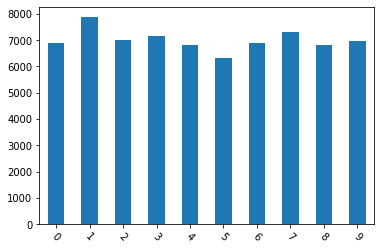

In [14]:
_ = (target.value_counts()
           .sort_index()
           .plot(kind="bar"))
_ = plt.xticks(rotation=-45)

### Visualize the data

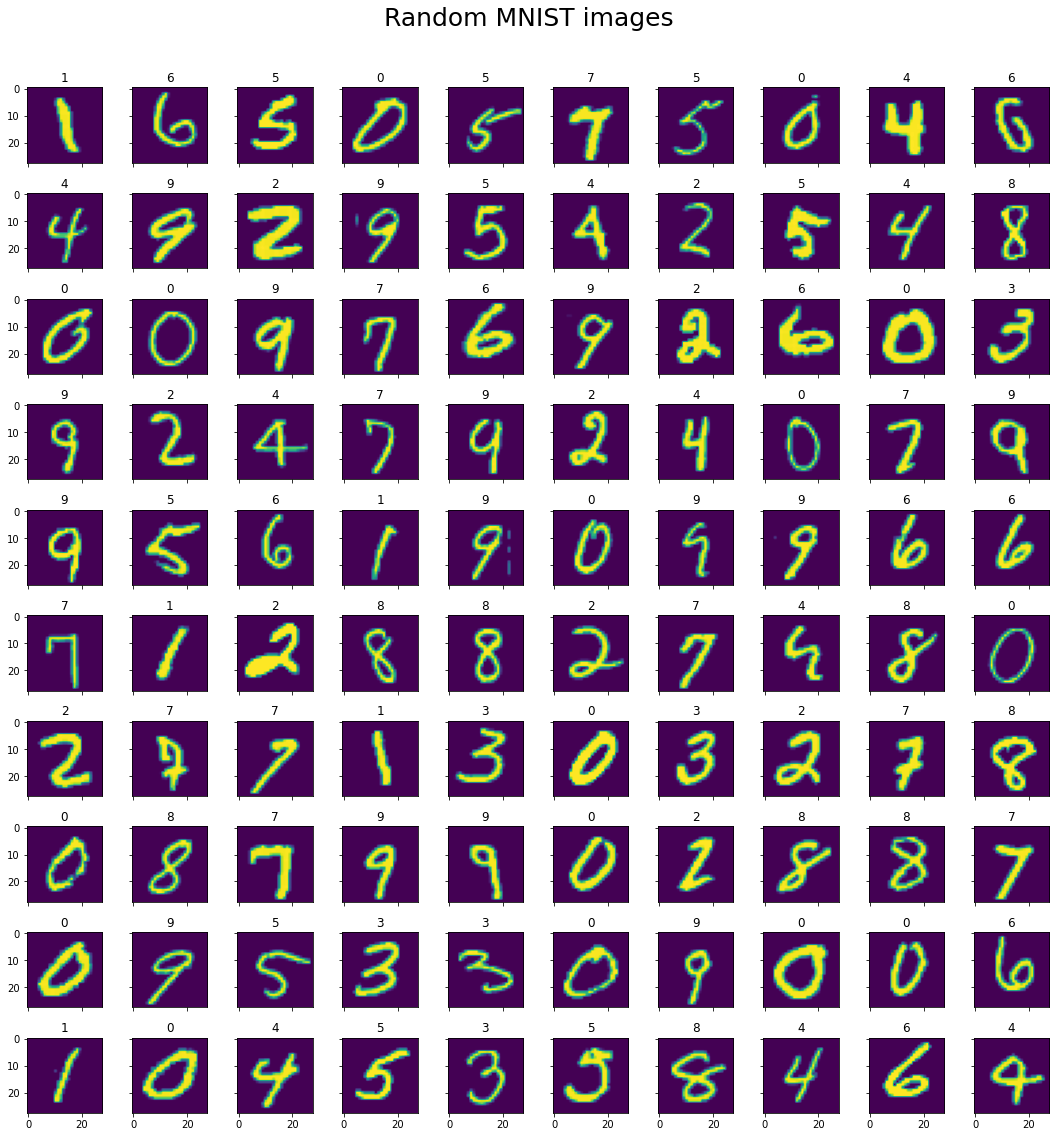

In [17]:
fig, axes = plt.subplots(10, 10, sharex=True, sharey=True, figsize=(15, 15))
for i in range(10):
    for j in range(10):
        m, _ = features.shape
        k = np.random.randint(m)
        img = (features.loc[k, :]
                       .to_numpy()
                       .reshape((28, 28)))
        _ = axes[i, j].imshow(img)
        _ = axes[i, j].set_title(target.iloc[k])

fig.suptitle("Random MNIST images", x=0.5, y=1.05, fontsize=25)
fig.tight_layout()

# Look at the Big Picture

Our goal over these two hands-on workshops will be to build a machine learning modeling pipeline that is capable of classifying images. In part one of this course we will mostly focus on classical machine learning algorithms implemented in Scikit-Learn; in part two we will revist the same problem using deep learning algorithms implemented in PyTorch. By the time you have finished this course you should understand how to build a machine learning application capable of classifying images and be ready to apply what you have learned to a new dataset.

This morning we will mostly focus on getting the data and exploring the data to gain new insights. Believe it or not these initial steps are what data scientists and machine learning engineers spend the majority of their time doing! This afternoon we will prepare our data for machine learning, see how to fit a variety of machine learning models to our dataset and shortlist a few candidate models for further analysis. We will then use hyper-parameter tuning to improve the performance of our shortlisted models to arrive at an overall best model. We will finish with a discussion of how to present the results of your model and talk about some of the aspects of deploying a trained model to make predictions.

## Framing the problem

### What is the business/research objective?

Typically building the model is not the overall objective but rather the model itself is one part of a larger process used to answer a business/research question. Knowing the overall objective is important because it will determine your choice of machine learning algorithms to train, your measure(s) of model performance, and how much time you will spend tweaking the hyper-parameters of your model.

In our example today, the overall business/research objective is to build a tool for reading electricity meter serial numbers which consist of sequences of sometimes handwritten digits. Part of this tool will be a model that can correctly classify individual handwritten digits. Our image classication model is just one of potentially many other models whose predictions are taken as inputs into another machine learning model that will be used to read off the electricity meter serial numbers. 

### What is the current solution?

Always a good idea to know what the current solution to the problem you are trying to solve. Current solution gives a benchmark for performance. Note that the current "best" solution could be very simple or could be very sophisticated. Understanding the current solution helps you think of a good place to start. Example: suppose that the current solution for predicting the price of a house in a given census block is to ignore all the demographic information and predict a simple average of house prices in nearby census blocks. In this case it would probably not make sense to start building a complicated deep learning model to predict housing prices. However, if the current solution was a tuned gradient boosted machine then it probably would not make sense to try a much simpler linear regression model.

With all this information, you are now ready to start designing your system. First, you need to frame the problem by answering the following questions.

* Is our problem supervised, unsupervised, or reinforcement learning?
* Is our problem a classification task, a regression task, or something else? If our problem is a classification task are we trying to classify samples into 2 categories (binary classification) or more than 2 (multi-class classification) categories? If our problem is a regression task, are we trying to predict a single value (univariate regression) or multiple values (multivariate regression) for each sample?
* Should you use batch learning or online learning techniques?


### Exercise: Selecting a metric

Scikit-Learn has a number of different [possible metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) that you can choose from (or you can create your own custom metric if required). Can you find a few metrics that seems appropriate for our image classification model?

# Creating a Test Dataset

Before we look at the data any further, we need to create a test set, put it aside, and never look at it (until we are ready to test our trainined machine learning model!). Why? We don't want our machine learning model to memorize our dataset (this is called overfitting). Instead we want a model that will generalize well (i.e., make good predictions) for inputs that it didn't see during training. To do this we hold split our dataset into training and testing datasets. The training dataset will be used to train our machine learning model(s) and the testing dataset will be used to make a final evaluation of our machine learning model(s).

## If you might refresh data in the future...

...then you want to use some particular hashing function to compute the hash of a unique identifier for each observation of data and include the observation in the test set if resulting hash value is less than some fixed percentage of the maximum possible hash value for your algorithm. This way even if you fetch more data, your test set will never include data that was previously included in the training data.

In [ ]:
import zlib


def in_testing_data(identifier, test_size):
    _hash = zlib.crc32(bytes(identifier))
    return _hash & 0xffffffff < test_size * 2**32


def split_train_test_by_id(data, test_size, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda identifier: in_testing_data(identifier, test_size))
    return data.loc[~in_test_set], data.loc[in_test_set]


## If this is all the data you will ever have...

...then you can just set a seed for the random number generator and then randomly split the data. Scikit-Learn has a [`model_selection`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) module that contains tools for splitting datasets into training and testing sets.

In [27]:
model_selection.train_test_split?

In [18]:
SEED = 42
SEED_GENERATOR = np.random.RandomState(SEED)


def generate_seed():
    return SEED_GENERATOR.randint(np.iinfo("uint16").max)

In [22]:
TEST_SIZE = 1e-1

# split the dataset into training and testing data
_seed = generate_seed()
_random_state = np.random.RandomState(_seed)
train_features, test_features, train_target, test_target = model_selection.train_test_split(
    features,
    target,
    test_size=TEST_SIZE,
    random_state=_random_state
)

In [23]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63000 entries, 24297 to 27483
Columns: 784 entries, pixel1 to pixel784
dtypes: uint8(784)
memory usage: 47.6 MB


In [24]:
train_features.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
24297,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36317,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31132,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42352,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16446,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
train_target.head()

24297    8
36317    1
31132    9
42352    7
16446    5
Name: label, dtype: uint8

In [26]:
train_features.describe()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,...,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.0,63000.0,63000.0,63000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.189841,0.090000,0.036111,0.008762,0.007841,0.000921,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.893693,3.965229,2.405637,0.921972,1.213741,0.231078,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,177.000000,254.000000,58.000000,0.0,0.0,0.0,0.0


Again, if you want to you can write out the train and test sets to disk to avoid having to recreate them later.

In [28]:
_ = (train_features.join(train_target)
                   .to_parquet(DATA_DIR / "train.parquet", index=False))

_ = (test_features.join(test_target)
                   .to_parquet(DATA_DIR / "test.parquet", index=False))

# Prepare the data for machine learning algorithms

Best practice is to write functions to automate the process of preparing your data for machine learning. Why?

* Allows you to reproduce these transformations easily on any dataset.
* You will gradually build a library of transformation functions that you can reuse in future projects.
* You can use these functions in a live system to transform the new data before feeding it to your algorithms.
* This will make it possible for you to easily experiment with various transformations and see which combination of transformations works best.

We are working with an benchmark dataset that has already been prepared for analysis (mostly!). You should be aware that academic benchmark datasets are not very representative of the type of datasets that you will encounter in most practical applications. 

## Feature Scaling

Machine learning algorithms typically don’t perform well when the input numerical attributes have very different scales. The simplest approach is to rescale features so that they all reside within the same range (typically between 0 and 1). This approach is implemented in Scikit-Learn by the [`preprocessing.MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) class.

In [30]:
preprocessing.MinMaxScaler?

In [31]:
# hyper-parameters
_preprocessing_hyperparameters = {
    "feature_range": (0, 1),
    "copy": True,
    "clip": False,
}

preprocessor = preprocessing.MinMaxScaler(**_preprocessing_hyperparameters)

In [32]:
preprocessed_train_features = preprocessor.fit_transform(train_features)

In [33]:
preprocessed_train_features.shape

(63000, 784)

In [34]:
preprocessed_train_features[:, :5]

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [35]:
preprocessed_train_features.min(axis=0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [36]:
preprocessed_train_features.mean(axis=0)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.72413793e-05, 2.93713286e-05, 1.58730159e-05, 1.58730159e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.58730159e-05, 3.14083080e-05, 5.33360237e-05, 1.00112486e-04,
       1.46606674e-04, 2.22786875e-04, 4.67538126e-04, 6.46436352e-04,
       7.61282291e-04, 7.99004046e-04, 8.63803299e-04, 7.15468410e-04,
       6.65981948e-04, 5.45845005e-04, 3.47463430e-04, 2.35543106e-04,
       1.92989418e-04, 7.73109244e-05, 5.21911663e-05, 1.70816211e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [37]:
preprocessed_train_features.max(axis=0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

The `preprocessing.MinMaxScaler` and the `preprocessing.StandardScaler` classes are the first Scikit-Learn `Transformer` classes that we have encountered. As such now is a good to to discuss the Scikit-Learn application programming interface (API). The [Scikit-Learn API](https://scikit-learn.org/stable/modules/classes.html) is one of the best designed API's around and has heavily influenced API design choices of other libraries in the Python Data Science and Machine Learning ecosystem, in particular [Dask](https://dask.org/) and [NVIDIA RAPIDS](https://rapids.ai/). Familiarly with the Scikit-Learn API will make it easier for you to get started with these libraries.

The Scikit-Learn API is built around the following key concepts.

* Estimators: Any object that can estimate some parameters based on a dataset is called an estimator (e.g., an `preprocessing.MinMaxScaler` is an estimator). The estimation itself is performed by the `fit` method, and it takes only a dataset as a parameter (or two for supervised learning algorithms; the second dataset contains the labels). Any other parameter needed to guide the estimation process is considered a hyperparameter (such as the `feature_range` parameter in `preprocessing.MinMaxScaler`), and it must be set as an instance variable (generally via a constructor parameter).

* Transformers: Some estimators (such as an `preprocessing.MinMaxScaler`) can also transform a dataset; these are called transformers. Once again, the API is simple: the transformation is performed by the transform method with the dataset to transform as a parameter. It returns the transformed dataset. This transformation generally relies on the learned parameters. All transformers also have a convenience method called `fit_transform` that is equivalent to calling `fit` and then `transform` (but sometimes `fit_transform` is optimized and runs much faster).

* Predictors: Finally, some estimators, given a dataset, are capable of making predictions; they are called predictors. A predictor has a `predict` method that takes a dataset of new instances and returns a dataset of corresponding predictions. It also has a score method that measures the quality of the predictions, given a test set (and the corresponding labels, in the case of supervised learning algorithms).

All of an estimator’s hyperparameters are accessible directly via public instance variables (e.g., `preprocessor.feature_range`), and all the estimator’s learned parameters are accessible via public instance variables with an underscore suffix (e.g., `preprocessor.scale_`). Finally, Scikit-Learn provides reasonable default values for most parameters which makes it easy to quickly create a baseline working system.

### Exercise: MinMaxScaler vs StandardScaler

An alternative approach is to rescale features so that they all have zero mean and unit standard deviation. This approach, which is also called standardization, is particularly useful when attributes/features have outliers and when downstream machine learning algorithms assume that attributes/features have a Gaussian or Normal distribution. 

Create an instance of the [`preprocessing.StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) class and use it to rescale the training dataset. Compare the two different rescaled versions of the dataset. Which of the two methods do you prefer?

In [38]:
_hyperparameters = {
    "copy": True,
    "with_mean": True,
    "with_std": True
}
preprocessor = preprocessing.StandardScaler(**_hyperparameters)

In [39]:
preprocessed_train_features = preprocessor.fit_transform(train_features)

In [40]:
preprocessed_train_features.mean(axis=0)

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        6.20315087e-19, -1.35341473e-18,  1.80455298e-18,  1.35341473e-18,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        6.76707367e-19,  1.24063017e-18, -9.02276490e-19,  2.48126035e-18,
        2.45306421e-18,  8.45884209e-18,  1.51131312e-17, -3.15796771e-18,
        6.42871999e-18, -1.26318709e-17, -1.08273179e-17, -9.02276490e-19,
        7.89491929e-18,  5.18808982e-18, -1.38725010e-17,  6.76707367e-18,
       -9.02276490e-18,  9.02276490e-19, -4.51138245e-19, -5.78020876e-19,
        0.00000000e+00,  

In [42]:
preprocessed_train_features.std(axis=0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

As with all the transformations, it is important to fit the scalers to the training data only, not to the full dataset (including the test set). Only then can you use them to transform the training set and the test set (and new data).

## Transformation pipelines

Creating preprocessing pipelines typically involves quite a lot of steps and each of the steps needs to be executed in the correct order. Fortunately Scikit-Learn allows you to combine estimators together to create [pipelines](https://scikit-learn.org/stable/modules/compose.html#combining-estimators). We can encapsulate all of the preprocessing logic into instances of the [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) class.

The `Pipeline` constructor takes a list of name/estimator pairs defining a sequence of steps. All but the last estimator must be transformers (i.e., they must have a `fit_transform` method). The names can be anything you like (as long as they are unique). Later we will see how to access the parameters of pipelines using these names when we discuss hyperparameter tuning.

In [43]:
_seed = generate_seed()

# hyper-parameters
_min_max_scaler_hyperparameters = {
    "feature_range": (0, 1)
}

# default Pipeline constructor
preparation_pipeline = pipeline.Pipeline(
    [
        ("minmaxscaler", preprocessing.MinMaxScaler(**_min_max_scaler_hyperparameters)),
    ],
    verbose=True,
)

In [44]:
# hyper-parameters
_min_max_scaler_hyperparameters = {
    "feature_range": (0, 1)
}

# alternative constructor that is equivalent to the above!
preparation_pipeline = pipeline.make_pipeline(
    preprocessing.MinMaxScaler(**_min_max_scaler_hyperparameters),
    verbose=True,
)

In [45]:
prepared_train_features = preparation_pipeline.fit_transform(train_features)

[Pipeline] ...... (step 1 of 1) Processing minmaxscaler, total=   0.6s


In [46]:
prepared_train_features.min(axis=0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [47]:
prepared_train_features.mean(axis=0)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.72413793e-05, 2.93713286e-05, 1.58730159e-05, 1.58730159e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.58730159e-05, 3.14083080e-05, 5.33360237e-05, 1.00112486e-04,
       1.46606674e-04, 2.22786875e-04, 4.67538126e-04, 6.46436352e-04,
       7.61282291e-04, 7.99004046e-04, 8.63803299e-04, 7.15468410e-04,
       6.65981948e-04, 5.45845005e-04, 3.47463430e-04, 2.35543106e-04,
       1.92989418e-04, 7.73109244e-05, 5.21911663e-05, 1.70816211e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [48]:
prepared_train_features.max(axis=0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

# Select and train a model

At last! You framed the problem, you got the data and explored it, you sampled a training set and a test set, and you wrote transformation pipelines to clean up and prepare your data for machine learning algorithms automatically. You are now ready to select and train a Machine Learning model. You might have been wondering if we were every going to make it to this point! Fact is, most of your time developing machine learning solutions to real-world problems will not be spent training machine learning models: most of your time will be spent preparing the data for machine learning algorithms and most of the computer time will be spent training the machine learning models.

## Training and evaluating on the training dataset

### Linear models

In [51]:
_seed = generate_seed()

# hyper-parameters
_min_max_scaler_hyperparameters = {
    "feature_range": (0, 1)
}

_classifier_hyperparameters = {
    "fit_intercept": True,
    "loss": "log",
    "penalty": None,
    "random_state": np.random.RandomState(_seed),
    "n_jobs": -1,
}

ml_pipeline = pipeline.make_pipeline(
    preprocessing.MinMaxScaler(**_min_max_scaler_hyperparameters),
    linear_model.SGDClassifier(**_classifier_hyperparameters),
    verbose=True,
)

In [52]:
_ = ml_pipeline.fit(train_features, train_target)

[Pipeline] ...... (step 1 of 2) Processing minmaxscaler, total=   0.5s
[Pipeline] ..... (step 2 of 2) Processing sgdclassifier, total= 1.9min


In [53]:
train_predictions = ml_pipeline.predict(train_features)

In [54]:
train_predictions

array([8, 1, 9, ..., 8, 1, 6], dtype=uint8)

### Mini-batch gradient descent

Since we talked about the difference between stochastic, batch, and mini-batch gradient descent in the lectures I wanted you to see how to implement mini-batch gradient descent in Scikit-Learn. You will see much more of this idea in the deep learning hands on session so we will not spend too much time on it now.

In [ ]:
_seed = generate_seed()
_random_state = np.random.RandomState(_seed)

n_epochs = 2
batch_size = 128
X = train_features
y = train_target
m, _ = X.shape

# define your estimator
_classifier_hyperparameters = {
    "alpha": 1e-4,
    "fit_intercept": False,
    "l1_ratio": 0.15,
    "learning_rate": "optimal",
    "loss": "log_loss",
    "n_jobs": -1,
    "penalty": None,
    "random_state": _random_state,
    "warm_start": True,
}
estimator = linear_model.SGDClassifier(**_classifier_hyperparameters)

# nested for loops implement the training
for _ in range(n_epochs):

    # shuffle the dataset before every training epoch
    shuffled_indices = _random_state.permutation(m)
    _X, _y = X.iloc[shuffled_indices], y.iloc[shuffled_indices]

    for batch_ixs in utils.gen_batches(m, batch_size):
        _ = estimator.partial_fit(_X[batch_ixs], _y[batch_ixs], classes=y.unique())


In [ ]:
train_predictions = estimator.predict(train_features)

In [ ]:
train_predictions

Congrats! You have fit your first machine learning model using Scikit-Learn and made some predictions. Now let's see how good those predictions really are.

### Evaluation metrics

#### Confusion matrix

In [55]:
confusion_matrix = metrics.confusion_matrix(
    train_target,
    train_predictions,
)
confusion_matrix

array([[5955,    1,   25,   12,   10,   50,   26,    9,   98,    6],
       [   0, 6835,   45,   29,    7,   48,    7,   12,   81,   19],
       [  35,   43, 5586,  136,   50,   49,   67,   63,  215,   20],
       [  19,   18,  155, 5606,   11,  217,   12,   52,  217,  101],
       [  12,   10,   47,   21, 5707,   42,   29,   26,  130,  189],
       [  47,   19,   33,  205,   52, 4958,   86,   23,  202,   71],
       [  26,   12,   59,   16,   30,  147, 5761,   13,   97,    2],
       [  18,   10,   55,   29,   48,   20,    1, 6121,   48,  229],
       [  36,   85,   89,  148,   35,  199,   37,   25, 5349,  118],
       [  21,   31,   13,   91,  200,   74,    1,  230,  116, 5504]])

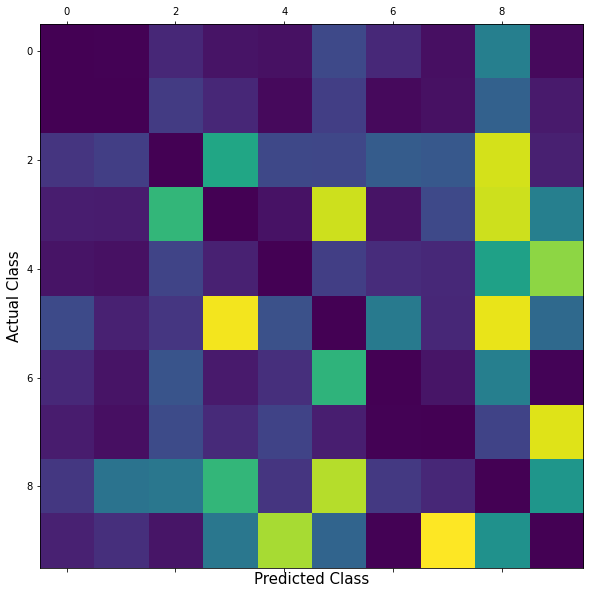

In [56]:
# visualize the normalized confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
_normalized_confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)
np.fill_diagonal(_normalized_confusion_matrix, 0)
_ = ax.matshow(_normalized_confusion_matrix)
_ = ax.set_xlabel("Predicted Class", fontsize=15)
_ = ax.set_ylabel("Actual Class", fontsize=15)
plt.show()

#### Precision

In [57]:
metrics.precision_score(
    train_target,
    train_predictions,
    average="macro",
)

0.9103216125073615

#### Recall

In [58]:
metrics.recall_score(
    train_target,
    train_predictions,
    average="macro",
)

0.909763803165799

#### $F_1$ Score

In [59]:
metrics.f1_score(
    train_target,
    train_predictions,
    average="macro",
)

0.9099001792065229

#### Receiver Operating Characteristic (ROC) Area Under the Curve (AUC) Score

In [60]:
_scores = ml_pipeline.predict_proba(train_features)
metrics.roc_auc_score(
    train_target,
    _scores,
    average="macro",
    multi_class="ovo",
)

0.9873846128628074

#### Classification report

In [61]:
_report = metrics.classification_report(
    train_target,
    train_predictions,
)
print(_report)

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      6192
           1       0.97      0.96      0.97      7083
           2       0.91      0.89      0.90      6264
           3       0.89      0.87      0.88      6408
           4       0.93      0.92      0.92      6213
           5       0.85      0.87      0.86      5696
           6       0.96      0.93      0.95      6163
           7       0.93      0.93      0.93      6579
           8       0.82      0.87      0.84      6121
           9       0.88      0.88      0.88      6281

    accuracy                           0.91     63000
   macro avg       0.91      0.91      0.91     63000
weighted avg       0.91      0.91      0.91     63000



### Estimating Generalization Error using Cross Validation

In [62]:
CV_FOLDS = 3

estimator_scores = model_selection.cross_val_score(
    ml_pipeline,
    X=train_features,
    y=train_target,
    cv=CV_FOLDS,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.3min finished


In [63]:
estimator_scores.mean()

0.8946507936507938

In [64]:
# make predictions
_train_predictions = model_selection.cross_val_predict(
    ml_pipeline,
    X=train_features,
    y=train_target,
    cv=CV_FOLDS,
    n_jobs=-1,
    verbose=1
)

# report the accuracy on the cv data
_report = metrics.classification_report(
    train_target,
    _train_predictions,
)
print(_report)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.3min finished


              precision    recall  f1-score   support

           0       0.95      0.96      0.95      6192
           1       0.96      0.96      0.96      7083
           2       0.88      0.88      0.88      6264
           3       0.85      0.86      0.86      6408
           4       0.91      0.91      0.91      6213
           5       0.82      0.85      0.84      5696
           6       0.95      0.93      0.94      6163
           7       0.92      0.92      0.92      6579
           8       0.82      0.83      0.82      6121
           9       0.87      0.84      0.86      6281

    accuracy                           0.89     63000
   macro avg       0.89      0.89      0.89     63000
weighted avg       0.90      0.89      0.89     63000



### Discussion

What is going on here? Are we underfitting? Are we overfitting? If you think that we are underfitting, then what could we do to try and get the model to overfit? If we are overfitting, what could we do to get the model to underfit?

### Exercise: Regularizing Linear Models

In [ ]:
linear_model.SGDClassifier?

In [ ]:
_seed = generate_seed()
_classifier_hyperparameters = {
    "alpha": 1e-4, # try changing this!
    "fit_intercept": True,
    "l1_ratio": 0.15, # only used for penalty=elastic_net
    "loss": "log",
    "n_jobs": -1,
    "penalty": None, # try changing this!
    "random_state": np.random.RandomState(_seed),
}

ml_pipeline = pipeline.make_pipeline(
    preprocessing.MinMaxScaler(),
    linear_model.SGDClassifier(**_classifier_hyperparameters),
    verbose=True,
)

# make predictions
_train_predictions = model_selection.cross_val_predict(
    ml_pipeline,
    X=train_features,
    y=train_target,
    cv=CV_FOLDS,
    n_jobs=-1,
    verbose=1
)

# report the accuracy on the training data
_report = metrics.classification_report(
    train_target,
    _train_predictions,
)
print(_report)

# Evaluate your models on the test dataset

After tweaking your models for a while, you eventually have a system that performs sufficiently well. Now is the time to evaluate the final model on the test set. First, we need to re-fit the pipeline using the full training data set.

In [65]:
_ = ml_pipeline.fit(train_features, train_target)

[Pipeline] ...... (step 1 of 2) Processing minmaxscaler, total=   0.6s
[Pipeline] ..... (step 2 of 2) Processing sgdclassifier, total= 2.0min


In [66]:
# make predictions
test_predictions = ml_pipeline.predict(test_features)

# generate a classification report
_report = metrics.classification_report(
    test_target,
    test_predictions,
)
print(_report)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       711
           1       0.95      0.96      0.96       794
           2       0.88      0.87      0.88       726
           3       0.88      0.86      0.87       733
           4       0.93      0.90      0.91       611
           5       0.80      0.88      0.83       617
           6       0.96      0.92      0.94       713
           7       0.91      0.90      0.90       714
           8       0.82      0.82      0.82       704
           9       0.87      0.86      0.86       677

    accuracy                           0.90      7000
   macro avg       0.89      0.89      0.89      7000
weighted avg       0.90      0.90      0.90      7000



Finally, we can save our trained model to disk for later use.

In [67]:
_ = joblib.dump(ml_pipeline, RESULTS_DIR / "linear-model.pkl")